In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [37]:
#read the human-labeled csv, CHANGE to your own directory
df = pd.read_csv('/Users/e5pianos/Desktop/2020 SPRING/COMP4641/project/lt_hydrator/lt_oid_info_train.csv',dtype=str,encoding='unicode_escape')

df = df[pd.notnull(df['label'])]
df = df[pd.notnull(df['full_text'])]

#input of the model will be text + quoted_text
df['full_text']=df['text'].fillna('') + ' ' + df['quoted_text'].fillna('')

<Figure size 720x288 with 0 Axes>

0.0    512
1.0    259
2.0    179
3.0     49
Name: label, dtype: int64


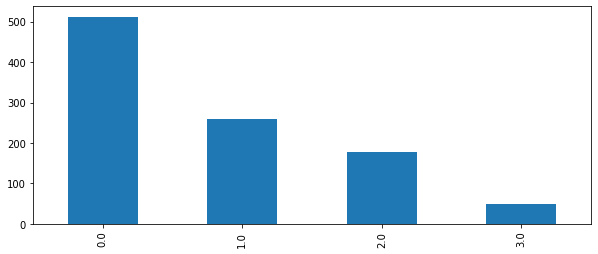

In [38]:
#statstic of classes, each class need to have at least 150 labels
my_tags = ['0','1','2','3']
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');
print(df.label.value_counts())

In [39]:
#remove redundant words
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['full_text'] = df['full_text'].apply(clean_text)

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning:

"https://t.co/RwSN2roOnD" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning:

"https://t.co/UIjEklo3Cs" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [40]:
df['full_text'].apply(lambda x: len(x.split(' '))).sum()

15256

In [57]:
#class rebalanced
zero=[]
one=[]
two=[]
three=[]
idx=0
for i in df.label:
    if i=='1.0':
        one.append(idx)
    elif i=='2.0':
        two.append(idx)
    elif i =='3.0':
        three.append(idx)
    else:
        zero.append(idx)
    idx=idx+1

#CHANGE the number of the sample to the smallest class, len(smallest class)
import random
#one=random.sample(one, len(three))
#two=random.sample(two, len(three))
zero=random.sample(zero, len(two))
al=one+two+three+zero

df_r=df[df.index.isin(al)]

##visulazed the new class (balanced), can remove comment if you want to check the result
#my_tags = ['0','1','2','3']
#plt.figure(figsize=(10,4))
#df_r.label.value_counts().plot(kind='bar');
#print(df_r.label.value_counts())
###

#split the train & test set to 7:3:

X = df_r.full_text
y = df_r.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


906    0.0
246    0.0
951    1.0
341    0.0
761    0.0
535    0.0
578    0.0
677    2.0
824    0.0
136    1.0
121    1.0
412    2.0
521    2.0
323    1.0
313    2.0
87     0.0
74     1.0
695    2.0
316    0.0
241    1.0
164    0.0
758    2.0
660    0.0
710    1.0
800    1.0
956    0.0
495    0.0
503    0.0
439    0.0
110    1.0
      ... 
525    1.0
729    0.0
589    0.0
506    2.0
777    1.0
222    1.0
637    1.0
60     2.0
59     0.0
104    1.0
255    1.0
356    1.0
864    0.0
92     1.0
15     0.0
318    1.0
805    2.0
642    0.0
497    0.0
874    0.0
930    0.0
894    1.0
271    0.0
624    2.0
612    0.0
124    0.0
851    0.0
488    2.0
633    0.0
119    0.0
Name: label, Length: 200, dtype: object


In [42]:
####Naive Bayes classifier for multinomial models

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = nb.predict(X_test)

#testing
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

accuracy 0.735
              precision    recall  f1-score   support

           0       0.72      0.94      0.81        86
           1       0.74      0.84      0.79        64
           2       0.86      0.31      0.45        39
           3       0.00      0.00      0.00        11

    accuracy                           0.73       200
   macro avg       0.58      0.52      0.51       200
weighted avg       0.71      0.73      0.69       200



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [43]:
#for confusion matrix

idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1


In [10]:
########Linear support vector machine
from sklearn.linear_model import SGDClassifier
import sklearn

sgd = sklearn.pipeline.Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)


#testing
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

accuracy 0.75
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        52
           1       0.76      0.86      0.81        83
           2       0.67      0.57      0.62        54
           3       0.67      0.55      0.60        11

    accuracy                           0.75       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.75      0.75      0.75       200



In [ ]:
#for confusion matrix

idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1

In [34]:
########Logistic regression

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))



AttributeError: 'TaggedDocument' object has no attribute 'lower'

In [ ]:
#for confusion matrix

idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1

In [12]:
###Word2vec embedding and Logistic Regression
from gensim.models import Word2Vec
from gensim import models
import gensim

#CHANGE to your own directory, takte times to import
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/e5pianos/Desktop/2020 SPRING/COMP4641/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

unable to import 'smart_open.gcs', disabling that module


KeyboardInterrupt: 

In [ ]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))
import nltk

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test.label, y_pred,target_names=my_tags))


In [ ]:
#for confusion matrix
idx=0
yl=[]
for i in X_test_word_average:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1

In [21]:
###BOW 
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df_r) * 0.7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df_r) - train_size))

train_posts = df_r['full_text'][:train_size]
train_tags = df_r['label'][:train_size]

test_posts = df_r['full_text'][train_size:]
test_tags = df_r['label'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


Train size: 466
Test size: 200


LabelEncoder()

In [22]:
batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 419 samples, validate on 47 samples
Epoch 1/20
419/419 [==============================] - 0s 589us/step - loss: 1.2525 - accuracy: 0.3986 - val_loss: 1.2333 - val_accuracy: 0.4043
Epoch 2/20
419/419 [==============================] - 0s 219us/step - loss: 0.9626 - accuracy: 0.6730 - val_loss: 1.1537 - val_accuracy: 0.5319
Epoch 3/20
419/419 [==============================] - 0s 226us/step - loss: 0.7706 - accuracy: 0.8305 - val_loss: 1.0759 - val_accuracy: 0.6596
Epoch 4/20
419/419 [==============================] - 0s 200us/step - loss: 0.5961 - accuracy: 0.8640 - val_loss: 1.0161 - val_accuracy: 0.6809
Epoch 5/20
419/419 [==============================] - 0s 214us/step - loss: 0.4692 - accuracy: 0.8998 - val_loss: 0.9613 - val_accuracy: 0.7447
Epoch 6/20
419/419 [==============================] - 0s 239us/step - loss: 0.3730 - accuracy: 0.9189 - val_loss: 0.9168 - val_accuracy: 0.7021
Epoch 7/20
419/419 [==============================] - 0s 266us/step - loss: 0.2886 - accura

In [24]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

200/200 [==============================] - 0s 82us/step
Test accuracy: 0.5799999833106995


In [ ]:
# for confusion matrix
text_labels = encoder.classes_ 


yl=[]

for i in x_test:
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    yl.append(predicted_label)
    #print("Predicted label: " + predicted_label + "\n")

In [26]:
##Doc2vec and Logistic Regression

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import gensim


def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled


X_train, X_test, y_train, y_test = train_test_split(df_r.full_text, df_r.label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [27]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

NameError: name 'Doc2Vec' is not defined

In [28]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

NameError: name 'model_dbow' is not defined

In [29]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [30]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

NameError: name 'train_vectors_dbow' is not defined

In [31]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

NameError: name 'train_vectors_dbow' is not defined

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [61]:
#for confusion matrix
idx=0
yl=[]
for i in test_vectors_dbow:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1

In [44]:
### confusion matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

[[54 32  6  0]
 [32 28  3  0]
 [25 11  5  0]
 [ 2  2  0  0]]


Text(0.5, 1.05, 'Confusion matrix of the classifier')

[Text(0, 1, ''),
 Text(0, 1, '0.0'),
 Text(0, 1, '1.0'),
 Text(0, 1, '2.0'),
 Text(0, 1, '3.0')]

[Text(0, 0, ''),
 Text(0, 0, '0.0'),
 Text(0, 0, '1.0'),
 Text(0, 0, '2.0'),
 Text(0, 0, '3.0')]

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'True')

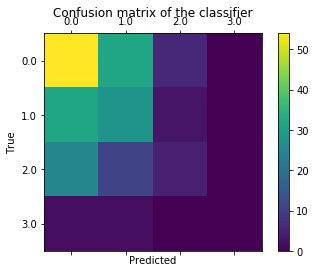

In [59]:
y_test_1d = y_test
y_pred_1d = yl

<Figure size 1728x1440 with 0 Axes>

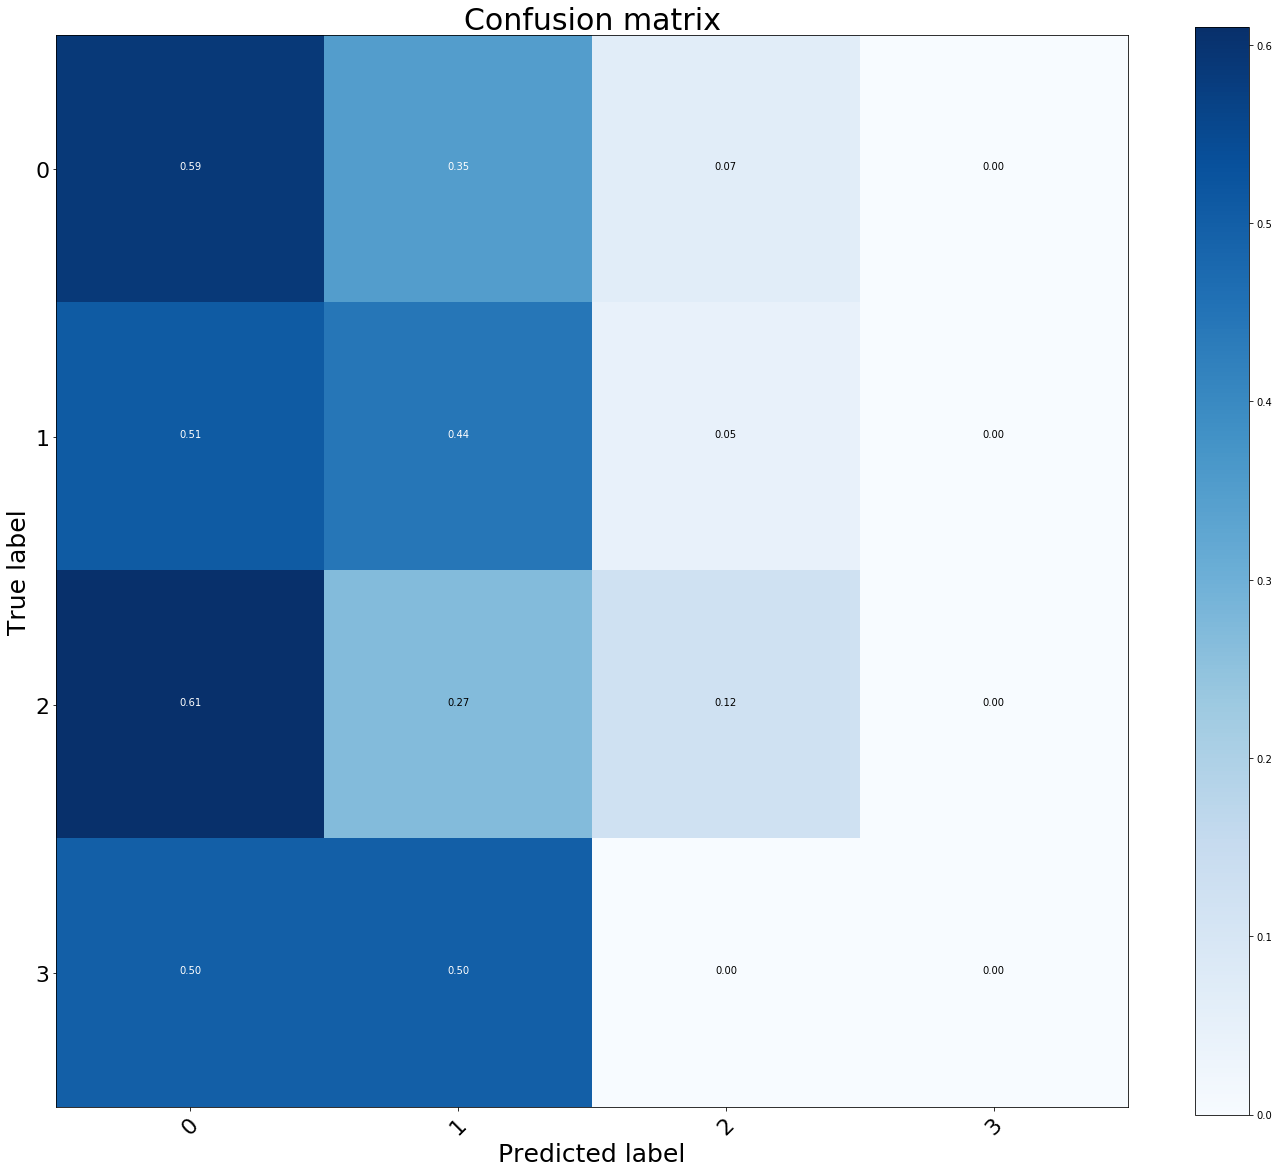

In [60]:

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
cls=[0,1,2,3]
plot_confusion_matrix(cnf_matrix, classes=cls, title="Confusion matrix")
plt.show()
